In [140]:
#!pip install spacy==3.4.0

In [141]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
import re
import random
from spacy.util import minibatch, compounding

import pandas as pd
import numpy as np
import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [142]:
import pandas as pd
import numpy as np
import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
# import spacy

# # Load the SpaCy English language model
# nlp = spacy.load('en_core_web_sm')

In [143]:
df = pd.read_csv('reddit_data.csv')
df.head()

,author,created_utc,title,subreddit,url,created,subtext
0,DerPres,1647627065,ClimateHoax,r/ClimateHoax Lounge,https://www.reddit.com/r/ClimateHoax/comments/...,1647641465.0,"{'author': 'DerPres', 'created_utc': 164762706..."
1,YoshiSatoshi,1486647033,climatehoax,Exxon Mobil Accuses the Rockefellers of a Clim...,http://nytimes.com/2016/11/21/science/exxon-mo...,1486661433.0,"{'author': 'YoshiSatoshi', 'created_utc': 1486..."
2,YoshiSatoshi,1482759500,climatehoax,Stunning photos capture rare snow in the Sahar...,http://www.telegraph.co.uk/news/2016/12/20/stu...,1482773900.0,"{'author': 'YoshiSatoshi', 'created_utc': 1482..."
3,YoshiSatoshi,1479851407,climatehoax,EXXON MOBIL ACCUSES THE ROCKEFELLERS OF A CLIM...,https://www.reddit.com/r/worldpolitics/comment...,1479865807.0,"{'author': 'YoshiSatoshi', 'created_utc': 1479..."
4,davidreiss666,1344600194,pollution,\nHow Your Water Company May Be Poisoning Your...,http://www.motherjones.com/kevin-drum/2012/08/...,1344614594,"{'author': 'davidreiss666', 'created_utc': 134..."


In [144]:
df.columns

Index(['author', 'created_utc', 'title', 'subreddit', 'url', 'created',
       'subtext'],
      dtype='object')

In [145]:
col = ["created_utc", "title", "subreddit"]
data_df = df[col]
data_df.columns = ["created_utc", "title", "post"]
data_df.head()

,created_utc,title,post
0,1647627065,ClimateHoax,r/ClimateHoax Lounge
1,1486647033,climatehoax,Exxon Mobil Accuses the Rockefellers of a Clim...
2,1482759500,climatehoax,Stunning photos capture rare snow in the Sahar...
3,1479851407,climatehoax,EXXON MOBIL ACCUSES THE ROCKEFELLERS OF A CLIM...
4,1344600194,pollution,\nHow Your Water Company May Be Poisoning Your...


In [146]:
def convert_lower(data_df, data_col):
    subRedit = []
    for i in data_df[data_col].values:
        text_lower = i.lower()
        subRedit.append(text_lower)
    data_df[data_col] = subRedit
    return data_df

subreddit_df = convert_lower(data_df = data_df, data_col="post")
subreddit_df.head()

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/3834393660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[data_col] = subRedit


,created_utc,title,post
0,1647627065,ClimateHoax,r/climatehoax lounge
1,1486647033,climatehoax,exxon mobil accuses the rockefellers of a clim...
2,1482759500,climatehoax,stunning photos capture rare snow in the sahar...
3,1479851407,climatehoax,exxon mobil accuses the rockefellers of a clim...
4,1344600194,pollution,\nhow your water company may be poisoning your...


In [147]:
title_df = convert_lower(data_df = subreddit_df, data_col="title")
title_df.head()

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/3834393660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[data_col] = subRedit


,created_utc,title,post
0,1647627065,climatehoax,r/climatehoax lounge
1,1486647033,climatehoax,exxon mobil accuses the rockefellers of a clim...
2,1482759500,climatehoax,stunning photos capture rare snow in the sahar...
3,1479851407,climatehoax,exxon mobil accuses the rockefellers of a clim...
4,1344600194,pollution,\nhow your water company may be poisoning your...


In [148]:
date_data = title_df["created_utc"].values
date_data

array([1647627065, 1486647033, 1482759500, ..., 1440254894, 1440254506,
       1395819974])

In [149]:
def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=datetime.timezone.utc).astimezone(tz=None)

In [150]:
data = [{
    'timestamp': utc_to_local(datetime.datetime.utcfromtimestamp(i))
} for i in date_data]

In [151]:
df_data = pd.DataFrame(data)
df_data.columns = ["time_stamp_utc"]
title_df["created_utc"] = df_data["time_stamp_utc"].values

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/3886942878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df["created_utc"] = df_data["time_stamp_utc"].values


In [152]:
title_df.head()

,created_utc,title,post
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...


In [153]:
df_data = title_df.copy()

#### Data Visualizations

In [154]:
import matplotlib.pyplot as plt
import datetime 
from collections import Counter

#### Years The Post Was Made

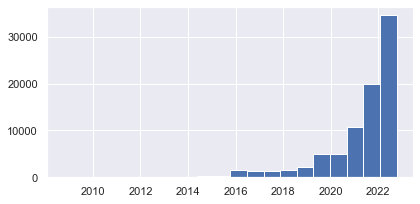

In [155]:
plt.figure(figsize=(6,3))
plt.hist(df_data['created_utc'], bins=20)
plt.tight_layout()
plt.show()

#### Weekdays The Post Was Made

<AxesSubplot:xlabel='weekdays'>

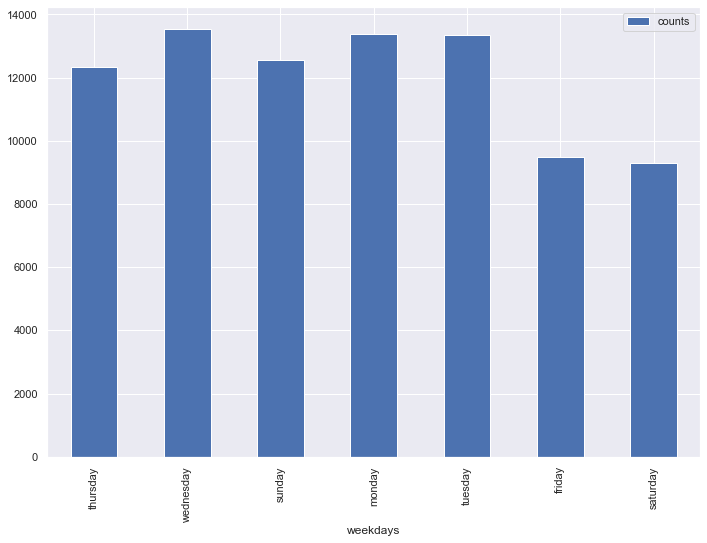

In [156]:
week_day = []
for i in range(83971):
    a = df_data["created_utc"][i].weekday()
    week_day.append(a)
    
week_data = {
    0: "sunday", 1:"monday", 2:"tuesday", 3:"wednesday",
    4:"thursday", 5:"friday", 6:"saturday"
}
week_day_vals = [week_data[i] for i in week_day]

week_day_comments = Counter(week_day_vals)
count_vals = [dict(week_day_comments)]
week_vals = pd.DataFrame(count_vals).T
new_index = week_vals.reset_index()
new_index.columns = ["weekdays", "counts"]

new_index.plot(x="weekdays", y="counts", kind="bar")

#### Hours These Posts??

<AxesSubplot:ylabel='hours'>

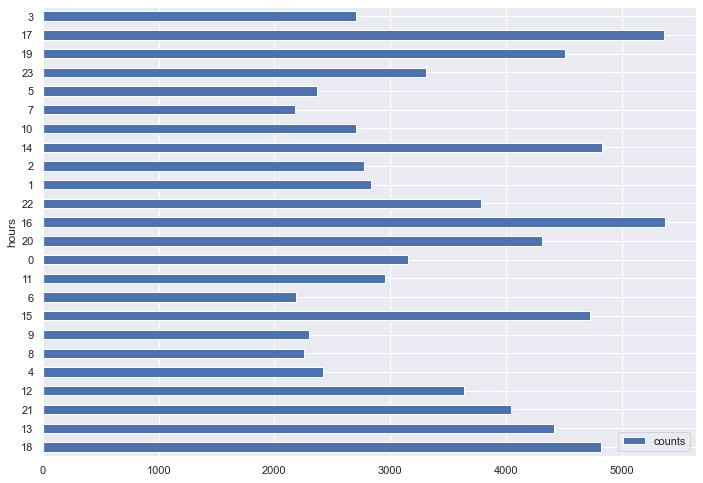

In [157]:
hour_time = []
for i in range(data_df.shape[0]):
    a = df_data["created_utc"][i].hour
    hour_time.append(a)
    
count_hour = Counter(hour_time)
count_vals = [dict(count_hour)]
#count_vals
hour_val = pd.DataFrame(count_vals).T
new_index = hour_val.reset_index()
new_index.columns = ["hours", "counts"]

new_index.plot(x="hours", y="counts", kind="barh")
# hour_time[0:10]

In [158]:
title_df

,created_utc,title,post
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...
...,...,...,...
83966,2015-10-18 06:59:27,fires,download unbroken full movie online | dvd9 dvd...
83967,2015-08-29 18:07:32,fires,helping our wa state firefighters « booktoots'...
83968,2015-08-22 14:48:14,fires,[helmet cam] (bendele) - working garage fire -...
83969,2015-08-22 14:41:46,fires,apartment fire


#### Data Cleaning

In [159]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Load the dataframe with text data
#df = pd.read_csv('your_file.csv')

# Define a function to clean the text data
def clean_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    # Remove punctuation and digits
    words = [re.sub(r'[^\w\s]|\d', '', word) for word in words]
    # Convert to lowercase
    words = [word.lower() for word in words]
    return ' '.join(words)

# Apply the cleaning function to relevant columns
title_df['cleaned_text'] = title_df["post"].apply(clean_text)

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]
word_arr = [f"word{i}" for i in range(len(stop_words))]
#print(word_arr)
top_words = dict(zip(word_arr, stop_words))

for word in top_words:
    title_df['cleaned_text'] = title_df['post'].str.replace(word, top_words[word])
title_df.head()

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/1138347597.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df['cleaned_text'] = title_df["post"].apply(clean_text)
/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/1138347597.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df['cleaned_text'] = title_df['post'].str.replace(word, top_words[word])


,created_utc,title,post,cleaned_text
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...


#### Lemmmatization, Tokenization, Stemming

In [160]:
title_df['tokens'] = title_df['cleaned_text'].apply(lambda x: word_tokenize(x.lower()))

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/1958883151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df['tokens'] = title_df['cleaned_text'].apply(lambda x: word_tokenize(x.lower()))


In [161]:
import string
def remove_punctuations(df_cols):
    new_cleaned = []
    punctuations = string.punctuation + '’‘“”'
    for i in df_cols.values:
        filtered_tokens = [token for token in i if not any(p in token for p in punctuations)]
        new_cleaned.append(filtered_tokens)
    df_cols = new_cleaned
    return df_cols

title_df["tokens"] = remove_punctuations(df_cols=title_df["tokens"])

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/1568422034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df["tokens"] = remove_punctuations(df_cols=title_df["tokens"])


In [162]:
title_df.head()

,created_utc,title,post,cleaned_text,tokens
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge,[lounge]
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,..."
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...,"[stunning, photos, capture, rare, snow, in, th..."
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,..."
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, poisoning..."


In [163]:
lemmatizer = WordNetLemmatizer()
title_df['lemmas'] = title_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/1786669667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df['lemmas'] = title_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [164]:
stemmer = PorterStemmer()
title_df['stems'] = title_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [165]:
title_df.head()

,created_utc,title,post,cleaned_text,tokens,lemmas,stems
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge,[lounge],[lounge],[loung]
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl..."
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...,"[stunning, photos, capture, rare, snow, in, th...","[stunning, photo, capture, rare, snow, in, the...","[stun, photo, captur, rare, snow, in, the, sah..."
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl..."
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, poisoning...","[how, your, water, company, may, be, poisoning...","[how, your, water, compani, may, be, poison, y..."


### Entity Relations

In [166]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
#import spacy
import matplotlib.pyplot as plt
import re
import random
#from spacy.util import minibatch, compounding

In [167]:
nlp = spacy.load('en_core_web_sm')
entities = []
count = 0
for review in title_df['cleaned_text']:
    ####you can increase count values from 50
    if count < 50:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL', 'ORG', 'PERSON')]
        entities.append(ents)
    count += 1

In [168]:
print(entities)

[[], [('exxon mobil', 'ORG')], [], [('exxon mobil', 'ORG')], [], [], [], [("bbc news - china's", 'ORG')], [], [], [('polluton nsfw', 'PERSON')], [], [], [], [('spring', 'DATE')], [], [], [], [], [], [('25', 'CARDINAL'), ('an average of 2 years', 'DATE')], [], [], [], [('oceans &amp', 'ORG')], [('hundreds', 'CARDINAL')], [('cars &', 'ORG')], [], [], [('epa', 'ORG')], [], [], [('epa', 'ORG')], [('un', 'ORG')], [], [], [], [('epa', 'ORG')], [], [('winter', 'DATE')], [], [('beaver lodge', 'ORG')], [], [('dozens', 'CARDINAL'), ('two', 'CARDINAL')], [], [('this month', 'DATE')], [], [('millions', 'CARDINAL'), ('next few decades', 'DATE')], [('house', 'ORG')], []]


In [169]:
ent_val = [i for i in entities if i != []]
ent_val

[[('exxon mobil', 'ORG')],
 [('exxon mobil', 'ORG')],
 [("bbc news - china's", 'ORG')],
 [('polluton nsfw', 'PERSON')],
 [('spring', 'DATE')],
 [('25', 'CARDINAL'), ('an average of 2 years', 'DATE')],
 [('oceans &amp', 'ORG')],
 [('hundreds', 'CARDINAL')],
 [('cars &', 'ORG')],
 [('epa', 'ORG')],
 [('epa', 'ORG')],
 [('un', 'ORG')],
 [('epa', 'ORG')],
 [('winter', 'DATE')],
 [('beaver lodge', 'ORG')],
 [('dozens', 'CARDINAL'), ('two', 'CARDINAL')],
 [('this month', 'DATE')],
 [('millions', 'CARDINAL'), ('next few decades', 'DATE')],
 [('house', 'ORG')]]

In [170]:
import spacy
nlp = spacy.load('en_core_web_sm') # load your model

from collections import Counter

ents = Counter()
entity_val = []
text = title_df["cleaned_text"].values[:100]
for n in text:
    for ent in nlp(n).ents:
        ents[f"{ent.label_}:{ent.text}"] += 1

    for key, val in ents.items():
        doc_val = f"{key}"
        entity_val.append(doc_val)

In [171]:
data_entity = []
for i in entity_val:
    b = i.split(":")
    data_entity.append(b)
ent_df = pd.DataFrame(data_entity, columns= ["attributes", "values"])
ent_df

,attributes,values
0,ORG,exxon mobil
1,ORG,exxon mobil
2,ORG,exxon mobil
3,ORG,exxon mobil
4,ORG,exxon mobil
...,...,...
4191,LOC,north america
4192,DATE,fourth-hottest
4193,LOC,south america
4194,LOC,africa


In [172]:
ent = ent_df["attributes"].unique()
ent

array(['ORG', 'GPE', 'NORP', 'PERSON', 'DATE', 'LOC', 'CARDINAL', 'MONEY',
       'QUANTITY', 'ORDINAL', 'TIME'], dtype=object)

In [173]:

data_entity = []
for i in entity_val:
    b = i.split(":")
    data_entity.append(b)
ent_df = pd.DataFrame(data_entity, columns= ["attributes", "values"])
ent_df

,attributes,values
0,ORG,exxon mobil
1,ORG,exxon mobil
2,ORG,exxon mobil
3,ORG,exxon mobil
4,ORG,exxon mobil
...,...,...
4191,LOC,north america
4192,DATE,fourth-hottest
4193,LOC,south america
4194,LOC,africa


In [174]:
ent_data = pd.DataFrame(ent_df.groupby("attributes")["values"].value_counts())
ent_data.loc["CARDINAL"][:5]

,values
values,
25,80
hundreds,75
dozens,57
two,57
millions,53


In [175]:
attr = ent_df["attributes"].unique()
emotion_vals = []
for i in attr:
    b = ent_data.loc[i][:5] 
    print(f"Top 5 {i} values are: ")
    print(b)

Top 5 ORG values are: 
                    values
values                    
exxon mobil             99
bbc news - china's      93
oceans &amp             76
cars &                  74
epa                     71
Top 5 GPE values are: 
         values
values         
wenzhou      95
canada       92
america      84
china        84
hanoi        75
Top 5 NORP values are: 
            values
values            
dans            91
european        80
vietnamese      75
british         65
canadian        59
Top 5 PERSON values are: 
                values
values                
polluton nsfw       90
° fahrenheit        17
biden               13
michelle obama       8
Top 5 DATE values are: 
                       values
values                       
spring                     86
an average of 2 years      80
winter                     61
this month                 55
next few decades           53
Top 5 LOC values are: 
               values
values               
asia               84
europe   

In [176]:
attr

array(['ORG', 'GPE', 'NORP', 'PERSON', 'DATE', 'LOC', 'CARDINAL', 'MONEY',
       'QUANTITY', 'ORDINAL', 'TIME'], dtype=object)

In [177]:
import numpy as np
import matplotlib.pyplot as plt

emotion_vals = []
for i in attr:
    b = ent_data.loc[i][:5] 
    emotion_vals.append(b)


/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_4338/2881088457.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  axes[i].barh(y_pos, [np.asscalar(val) for val in vals.values], align='center', color='blue')


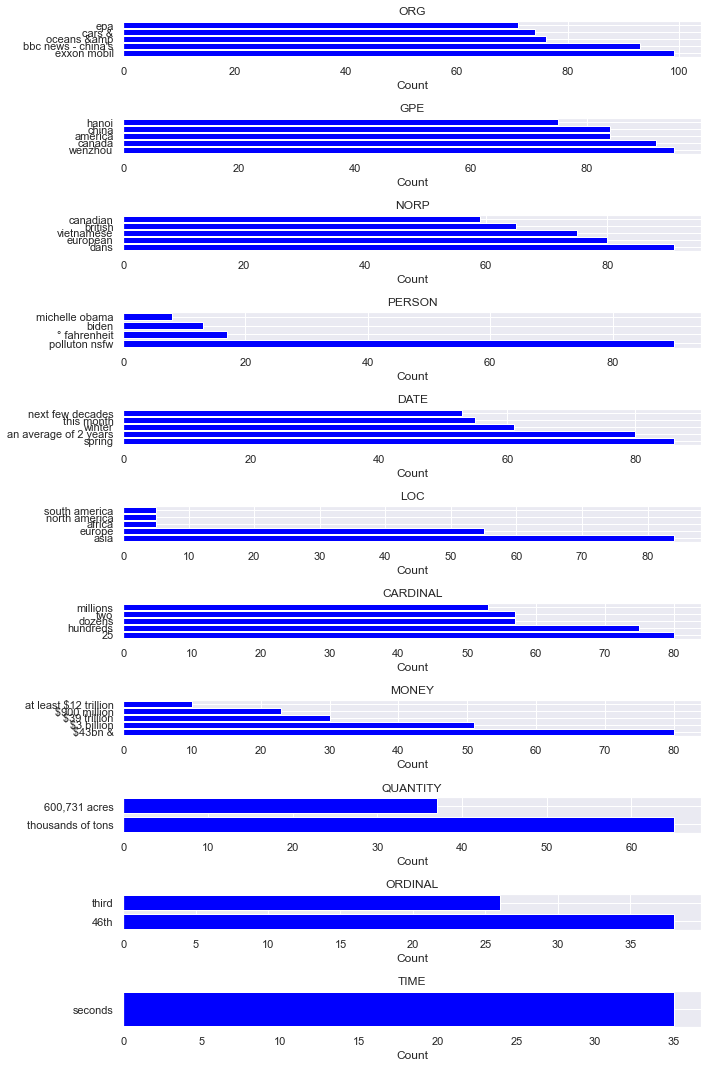

In [178]:
fig, axes = plt.subplots(nrows=len(emotion_vals), figsize=(10, 15))

for i, vals in enumerate(emotion_vals):
    #print(i)
    y_pos = np.arange(len(vals))
    axes[i].barh(y_pos, [np.asscalar(val) for val in vals.values], align='center', color='blue')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(vals.index)
    axes[i].set_xlabel('Count')
    axes[i].set_title(f"{attr[i]}")

fig.tight_layout()
plt.show()

#### Emotion Recognition

In [179]:
from nrclex import NRCLex

In [180]:
str_tweet = ",".join(title_df["cleaned_text"])
text_object = NRCLex(str_tweet)

In [181]:
emot_data = []
for i in range(0, len(title_df["cleaned_text"].values)):
    a = title_df["cleaned_text"][i]
    object_text = NRCLex(a)
    data_val = object_text.raw_emotion_scores
    emot_data.append(data_val)
df_emotion_data = pd.DataFrame(emot_data)
df_emotion_data.head()

,negative,fear,anger,disgust,sadness,surprise,anticipation,joy,positive,trust
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
em_sentiment = pd.concat([title_df, df_emotion_data], axis=1)
em_sentiment.head()

,created_utc,title,post,cleaned_text,tokens,lemmas,stems,negative,fear,anger,disgust,sadness,surprise,anticipation,joy,positive,trust
0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge,[lounge],[lounge],[loung],1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl...",NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...,"[stunning, photos, capture, rare, snow, in, th...","[stunning, photo, capture, rare, snow, in, the...","[stun, photo, captur, rare, snow, in, the, sah...",2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl...",1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, poisoning...","[how, your, water, company, may, be, poisoning...","[how, your, water, compani, may, be, poison, y...",1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


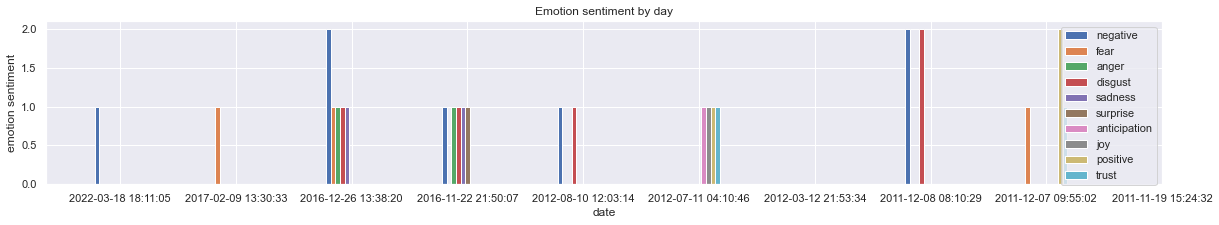

In [183]:
import matplotlib.pyplot as plt
import numpy as np

data = em_sentiment[:10] ###You can increase the counts from 10 to as much as you want!
X = data["created_utc"]
emotions = ["negative", "fear", "anger", "disgust", "sadness", "surprise", "anticipation", "joy", "positive", "trust"]
emotions_data = [data[emotion] for emotion in emotions]

plt.rcParams["figure.figsize"] = (20,3)
X_axis = np.arange(len(X))

for i in range(len(emotions)):
    plt.bar(X_axis - 0.2 + i*0.04, emotions_data[i], 0.04, label=emotions[i])

plt.xticks(X_axis, X)
plt.xlabel("date")
plt.ylabel("emotion sentiment")
plt.title("Emotion sentiment by day")
plt.legend()
plt.show()

In [184]:
# title_df.head()

In [185]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

In [186]:
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [187]:
sia = SentimentIntensityAnalyzer()

In [188]:
dataframe = df_data.reset_index()
dataframe.columns
#dataframe.columns = ["Id", "Time", "Title", "Text"]

Index(['index', 'created_utc', 'title', 'post'], dtype='object')

In [190]:
result = {}
for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row['post']
    id = row['index']
    result[id] = sia.polarity_scores(text)
    
# Convert result dictionary into dataframe
vaders = pd.DataFrame(result).T
vaders
# Merge result with the input dataframe
# vaders = vaders.reset_index().rename(columns={'index':'Id'})
# vaders = vaders.merge(dataframe, how='left')
# vaders.head()

  0%|          | 0/83971 [00:00<?, ?it/s]

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.492,0.508,0.000,-0.7003
2,0.000,0.755,0.245,0.3818
3,0.429,0.571,0.000,-0.5423
4,0.322,0.678,0.000,-0.5859
...,...,...,...,...
83966,0.000,1.000,0.000,0.0000
83967,0.000,0.732,0.268,0.2960
83968,0.286,0.714,0.000,-0.3400
83969,0.706,0.294,0.000,-0.3400


In [191]:
vaders_df = vaders.reset_index().rename(columns={'index':'Id'})
vaders_df.head()

,Id,neg,neu,pos,compound
0,0,0.000,1.000,0.000,0.0000
1,1,0.492,0.508,0.000,-0.7003
2,2,0.000,0.755,0.245,0.3818
3,3,0.429,0.571,0.000,-0.5423
4,4,0.322,0.678,0.000,-0.5859


In [192]:
vaders_df.shape

(83971, 5)

In [193]:
df_vad = pd.concat([vaders_df, data_df], axis=1)
df_vad.head()

,Id,neg,neu,pos,compound,created_utc,title,post,cleaned_text,tokens,lemmas,stems
0,0,0.000,1.000,0.000,0.0000,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge,[lounge],[lounge],[loung]
1,1,0.492,0.508,0.000,-0.7003,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl..."
2,2,0.000,0.755,0.245,0.3818,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...,"[stunning, photos, capture, rare, snow, in, th...","[stunning, photo, capture, rare, snow, in, the...","[stun, photo, captur, rare, snow, in, the, sah..."
3,3,0.429,0.571,0.000,-0.5423,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl..."
4,4,0.322,0.678,0.000,-0.5859,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, poisoning...","[how, your, water, company, may, be, poisoning...","[how, your, water, compani, may, be, poison, y..."


In [194]:
df_vad["compound"] = round(df_vad["compound"], 1)
ps = []
for n in df_vad["compound"].values:
    if n > 0:
        ps.append("positive")
    elif n < 0:
        ps.append("negative")
    else:
        ps.append("neutral")
pscore = pd.DataFrame(ps, columns=["sentiment_val"])
df_ps = pd.concat([df_vad, pscore], axis=1)
df_ps.head()

,Id,neg,neu,pos,compound,created_utc,title,post,cleaned_text,tokens,lemmas,stems,sentiment_val
0,0,0.000,1.000,0.000,0.0,2022-03-18 18:11:05,climatehoax,r/climatehoax lounge,r/climatehoax lounge,[lounge],[lounge],[loung],neutral
1,1,0.492,0.508,0.000,-0.7,2017-02-09 13:30:33,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl...",negative
2,2,0.000,0.755,0.245,0.4,2016-12-26 13:38:20,climatehoax,stunning photos capture rare snow in the sahar...,stunning photos capture rare snow in the sahar...,"[stunning, photos, capture, rare, snow, in, th...","[stunning, photo, capture, rare, snow, in, the...","[stun, photo, captur, rare, snow, in, the, sah...",positive
3,3,0.429,0.571,0.000,-0.5,2016-11-22 21:50:07,climatehoax,exxon mobil accuses the rockefellers of a clim...,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, accuses, the, rockefellers, of,...","[exxon, mobil, accuses, the, rockefeller, of, ...","[exxon, mobil, accus, the, rockefel, of, a, cl...",negative
4,4,0.322,0.678,0.000,-0.6,2012-08-10 12:03:14,pollution,\nhow your water company may be poisoning your...,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, poisoning...","[how, your, water, company, may, be, poisoning...","[how, your, water, compani, may, be, poison, y...",negative


In [195]:
plt_sent = df_ps["sentiment_val"].value_counts().reset_index()
plt_sent
#plt.pie(plt_sent["sentiment_val"], labels=plt_sent["index"], )

,index,sentiment_val
0,neutral,34638
1,positive,26638
2,negative,22695


([<matplotlib.patches.Wedge at 0x7fe62b203970>,
 [Text(-1.1549458201902227, 0.32573018347266136, 'neutral'),
  Text(0.5185213509424392, -1.0821901905935147, 'positive'),
  Text(0.9008108929776524, 0.7928049792305827, 'negative')],
 [Text(-0.6737183951109633, 0.1900092736923858, '41.25%'),
  Text(0.30247078804975625, -0.6312776111795503, '31.72%'),
  Text(0.5254730209036305, 0.4624695712178398, '27.03%')])

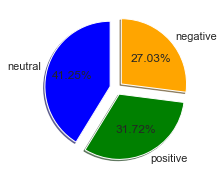

In [196]:
import matplotlib.pyplot as plt
colors =["blue", "green", "orange"]
plt.pie(np.array(plt_sent["sentiment_val"]), labels=np.array(plt_sent["index"]), colors=colors,  
        startangle=90, shadow=True,explode=(0.1, 0.1, 0.1), autopct='%1.2f%%')

In [197]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [198]:
df_ps.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'created_utc', 'title', 'post',
       'cleaned_text', 'tokens', 'lemmas', 'stems', 'sentiment_val'],
      dtype='object')

In [199]:
raw_data = title_df[['created_utc','cleaned_text']]
raw_data.columns = ["time", "post"]
raw_data.head()

,time,post
0,2022-03-18 18:11:05,r/climatehoax lounge
1,2017-02-09 13:30:33,exxon mobil accuses the rockefellers of a clim...
2,2016-12-26 13:38:20,stunning photos capture rare snow in the sahar...
3,2016-11-22 21:50:07,exxon mobil accuses the rockefellers of a clim...
4,2012-08-10 12:03:14,\nhow your water company may be poisoning your...


In [200]:
reindexed_data = raw_data['post']
reindexed_data.index = raw_data['time']
reindexed_data.head()

time
2022-03-18 18:11:05                                 r/climatehoax lounge
2017-02-09 13:30:33    exxon mobil accuses the rockefellers of a clim...
2016-12-26 13:38:20    stunning photos capture rare snow in the sahar...
2016-11-22 21:50:07    exxon mobil accuses the rockefellers of a clim...
2012-08-10 12:03:14    \nhow your water company may be poisoning your...
Name: post, dtype: object

#### Vectorization

In [201]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

#### Top Words

In [202]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

print(words)
print(word_values)

['climate', 'change', 'energy', 'new', 'global', 'green', 'carbon', 'world', 'power', 'warming', 'gas', 'solar', 'oil', 'emissions', 'help']
[19108, 9601, 5634, 4764, 3936, 3220, 3209, 3196, 2821, 2711, 2609, 2560, 2312, 2138, 1913]


<AxesSubplot:xlabel='counts', ylabel='top_words'>

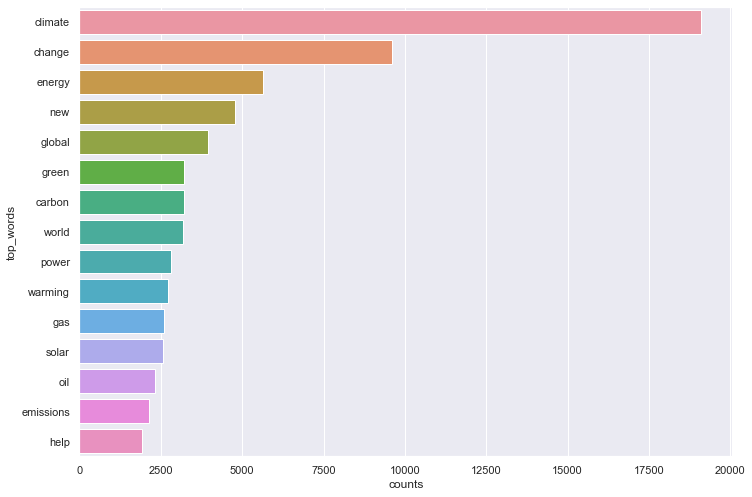

In [203]:
data_top_words = pd.DataFrame([words, word_values]).T
data_top_words.columns = ["top_words", "counts"]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='counts', y='top_words', data=data_top_words, orient="h")

In [204]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [205]:
analyzer = SentimentIntensityAnalyzer()

In [206]:
df = raw_data.copy()
df.columns

Index(['time', 'post'], dtype='object')

In [207]:
def get_neutral_words(post):
    words = post.split()
    neutral_words = [word for word in words if analyzer.polarity_scores(word)['compound'] == 0]
    return neutral_words

In [208]:
df['neutral_words'] = df['post'].apply(get_neutral_words)

In [209]:
df['sentiment_score'] = df['post'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment_class'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else ('neutral' if score == 0 else 'negative'))
df['positive_words'] = df['post'].apply(lambda x: [word for word in x.split() if analyzer.polarity_scores(word)['compound'] > 0])
df['negative_words'] = df['post'].apply(lambda x: [word for word in x.split() if analyzer.polarity_scores(word)['compound'] < 0])


In [210]:
df.head()

,time,post,neutral_words,sentiment_score,sentiment_class,positive_words,negative_words
0,2022-03-18 18:11:05,r/climatehoax lounge,"[r/climatehoax, lounge]",0.0000,neutral,[],[]
1,2017-02-09 13:30:33,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, the, rockefellers, of, a, climate]",-0.7003,negative,[],"[accuses, conspiracy]"
2,2016-12-26 13:38:20,stunning photos capture rare snow in the sahar...,"[photos, capture, rare, snow, in, the, sahara,...",0.3818,positive,[stunning],[]
3,2016-11-22 21:50:07,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, the, rockefellers, of, a, climate]",-0.5423,negative,[],"[accuses, hoax]"
4,2012-08-10 12:03:14,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, your, kids]",-0.5859,negative,[],[poisoning]


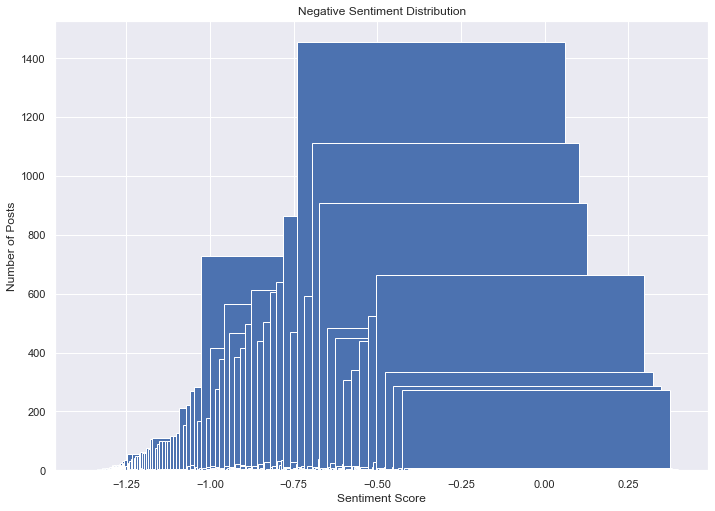

In [211]:
import matplotlib.pyplot as plt

# Filter the dataframe to only include negative sentiment posts
neg_df = df[df['sentiment_class'] == 'negative']

# Count the number of negative sentiment posts for each category
neg_counts = neg_df['sentiment_score'].value_counts().sort_index()

# Plot the bar chart
fig, ax = plt.subplots()
ax.bar(neg_counts.index, neg_counts.values)
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Number of Posts')
ax.set_title('Negative Sentiment Distribution')
plt.show()

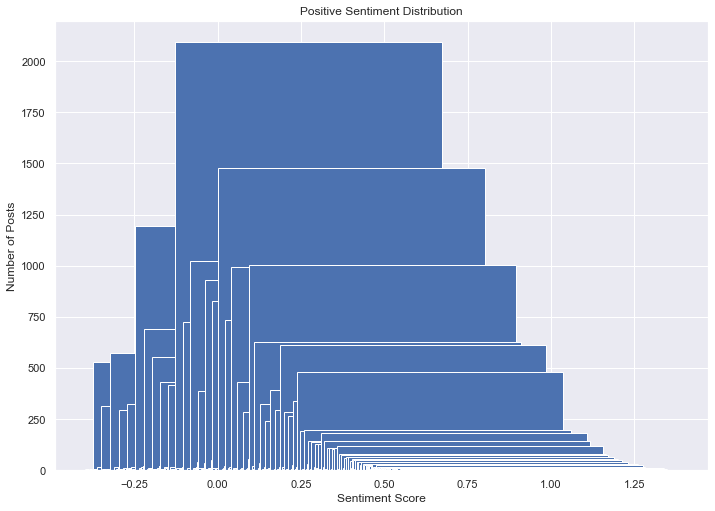

In [212]:
postv_df = df[df['sentiment_class'] == 'positive']

# Count the number of negative sentiment posts for each category
pos_counts = postv_df['sentiment_score'].value_counts().sort_index()

# Plot the bar chart
fig, ax = plt.subplots()
ax.bar(pos_counts.index, pos_counts.values)
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Number of Posts')
ax.set_title('Positive Sentiment Distribution')
plt.show()

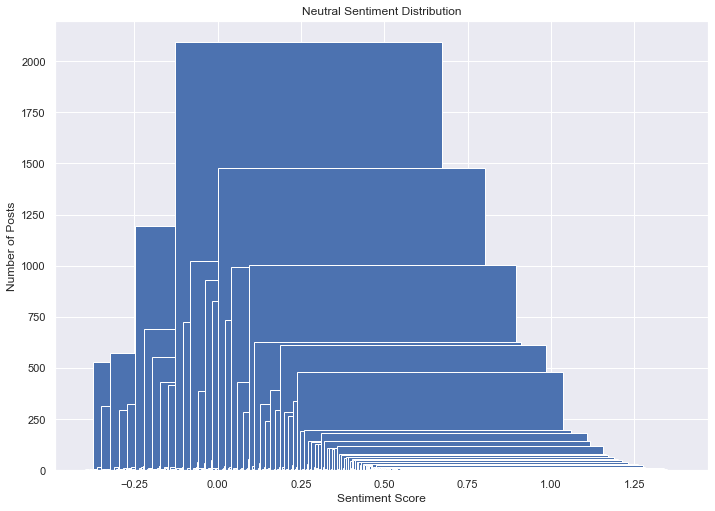

In [213]:
neu_df = df[df['sentiment_class'] == 'neutral']

# Count the number of negative sentiment posts for each category
neu_counts = neu_df['sentiment_score'].value_counts().sort_index()

# Plot the bar chart
fig, ax = plt.subplots()
ax.bar(pos_counts.index, pos_counts.values)
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Number of Posts')
ax.set_title('Neutral Sentiment Distribution')
plt.show()

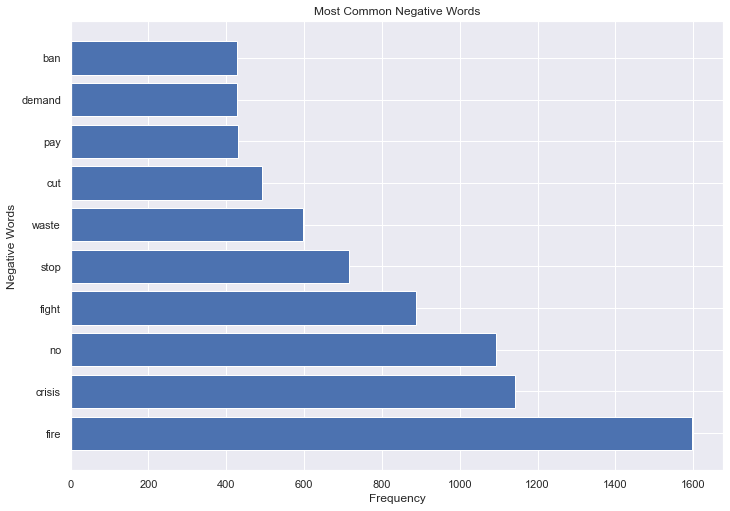

In [214]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all the negative words into a single list
all_neg_words = [word for post in df['negative_words'] for word in post]

# Count the occurrences of each negative word
word_counts = Counter(all_neg_words)

# Create a list of the most common negative words and their counts
most_common = word_counts.most_common(10)

# Create a horizontal bar plot of the most common negative words
fig, ax = plt.subplots()
ax.barh([word[0] for word in most_common], [word[1] for word in most_common])
ax.set_xlabel('Frequency')
ax.set_ylabel('Negative Words')
ax.set_title('Most Common Negative Words')
plt.show()

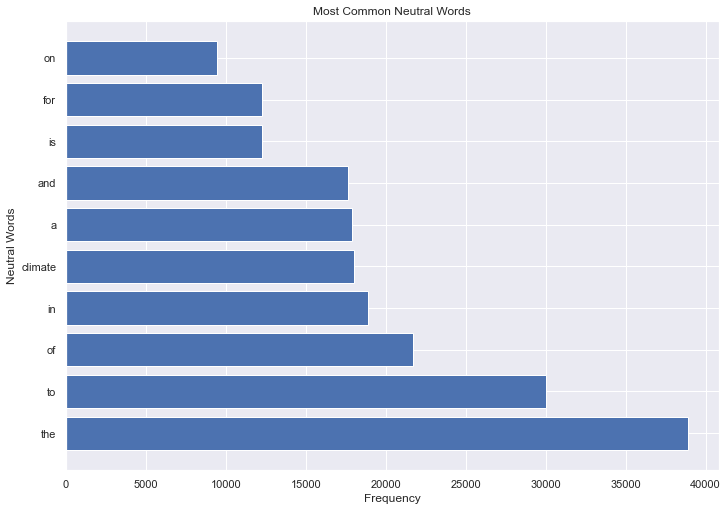

In [215]:
# Combine all the negative words into a single list
all_neu_words = [word for post in df['neutral_words'] for word in post]

# Count the occurrences of each negative word
word_counts = Counter(all_neu_words)

# Create a list of the most common negative words and their counts
most_common = word_counts.most_common(10)

# Create a horizontal bar plot of the most common negative words
fig, ax = plt.subplots()
ax.barh([word[0] for word in most_common], [word[1] for word in most_common])
ax.set_xlabel('Frequency')
ax.set_ylabel('Neutral Words')
ax.set_title('Most Common Neutral Words')
plt.show()

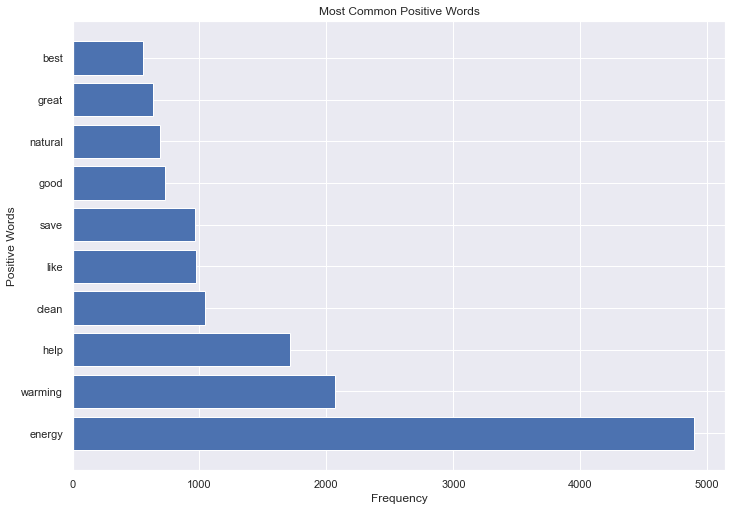

In [216]:
all_pos_words = [word for post in df['positive_words'] for word in post]

# Count the occurrences of each positive word
word_counts = Counter(all_pos_words)

# Create a list of the most common positive words and their counts
most_common = word_counts.most_common(10)

# Create a horizontal bar plot of the most common positive words
fig, ax = plt.subplots()
ax.barh([word[0] for word in most_common], [word[1] for word in most_common])
ax.set_xlabel('Frequency')
ax.set_ylabel('Positive Words')
ax.set_title('Most Common Positive Words')
plt.show()

In [217]:
#df['sentiment_score'] = df['post'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

#### Positive Word Counts

In [218]:
df.head()

,time,post,neutral_words,sentiment_score,sentiment_class,positive_words,negative_words
0,2022-03-18 18:11:05,r/climatehoax lounge,"[r/climatehoax, lounge]",0.0000,neutral,[],[]
1,2017-02-09 13:30:33,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, the, rockefellers, of, a, climate]",-0.7003,negative,[],"[accuses, conspiracy]"
2,2016-12-26 13:38:20,stunning photos capture rare snow in the sahar...,"[photos, capture, rare, snow, in, the, sahara,...",0.3818,positive,[stunning],[]
3,2016-11-22 21:50:07,exxon mobil accuses the rockefellers of a clim...,"[exxon, mobil, the, rockefellers, of, a, climate]",-0.5423,negative,[],"[accuses, hoax]"
4,2012-08-10 12:03:14,\nhow your water company may be poisoning your...,"[how, your, water, company, may, be, your, kids]",-0.5859,negative,[],[poisoning]


### Word Cloud

In [219]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
#import spacy
import matplotlib.pyplot as plt
import re
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [220]:
def get_words(x):
    words = []
    for i in x.values:
        if i != []:
            for n in i:
                words.append(n)
    return words
                
positive_words = get_words(x= df["positive_words"])
negative_words = get_words(x= df["negative_words"])
neutral_words = get_words(x=df["neutral_words"])

### Positive Words

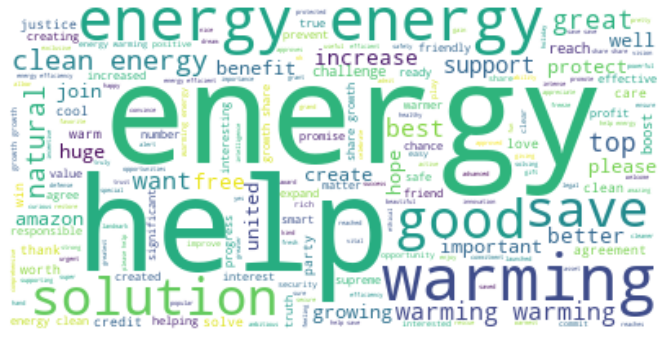

In [221]:
word_string = " ".join(positive_words)

# Define the stopwords to exclude from the word cloud
stopwords = set(STOPWORDS)
stopwords.add("said")  # add additional stopword

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(word_string)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Words

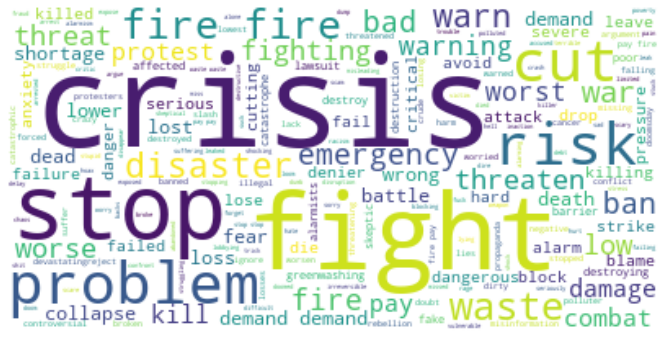

In [222]:
word_string = " ".join(negative_words)

# Define the stopwords to exclude from the word cloud
stopwords = set(STOPWORDS)
stopwords.add("said")  # add additional stopword

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(word_string)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Neutral Words

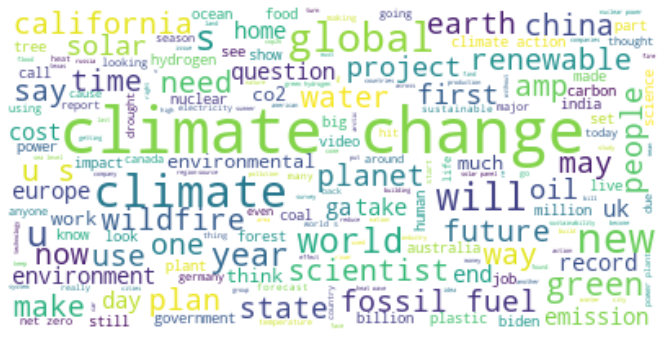

In [223]:
word_string = " ".join(neutral_words)

# Define the stopwords to exclude from the word cloud
stopwords = set(STOPWORDS)
stopwords.add("said")  # add additional stopword

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(word_string)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [224]:

#from spacy.util import minibatch, compounding